<a href="https://colab.research.google.com/github/Reeshad-Khan/Machine-Learning/blob/master/The_tensorflow_version_magic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TensorFlow versions in Colab


##Background
Colab has two versions of TensorFlow pre-installed: a 2.x version and a 1.x version. Colab uses TensorFlow 2.x by default, though you can switch to 1.x by the method shown below.


##Specifying the TensorFlow version

Running `import tensorflow` will import the default version (currently 2.x). You can use 1.x by running a cell with the `tensorflow_version` magic **before** you run `import tensorflow`.

In [1]:
%tensorflow_version 2.2

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.2`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


Once you have specified a version via this magic, you can run `import tensorflow` as normal and verify which version was imported as follows:

In [1]:
import tensorflow
print(tensorflow.__version__)

2.2.0


If you want to switch TensorFlow versions after import, you **will need to restart your runtime** with 'Runtime' -> 'Restart runtime...' and then specify the version before you import it again.

## Avoid Using ``pip install`` with GPUs and TPUs

We recommend against using ``pip install`` to specify a particular TensorFlow version for both GPU and TPU backends. Colab builds TensorFlow from source to ensure compatibility with our fleet of accelerators. Versions of TensorFlow fetched from PyPI by ``pip`` may suffer from performance problems or may not work at all.

**Task**




Implement the time series prediction with jena climate dataset using Recurrent Network Layers, try to pass different arguments to observe the result, plot the results and analyze the differences. There are many other things to try, in order to improve performance on the temperature-forecasting problem:
* Adjust the number of units in each recurrent layer in the stacked setup


* Adjust the learning rate used by the RMSprop optimizer.
* Try using LSTM layers instead of GRU layers.
* Try using a bigger densely connected regressor on top of the recurrent layers: Don't forget to eventually run the best-performing models on the test set! Otherwise, you'll develop architectures that 

### **1 Download and plot jena climate data**

**1.1 Download data set**

https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip (https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip)

In [2]:
import os
data_dir = '/content/sample_data'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


### **1.2 Parsing the data and convert all of data into a Numpy array**


In [0]:
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

### **1.3 Plot of temperature**

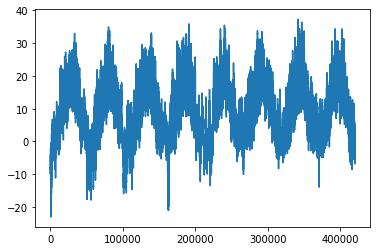

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
temp = float_data[:, 1] # temperature (in degrees Celsius)
plt.plot(temp)

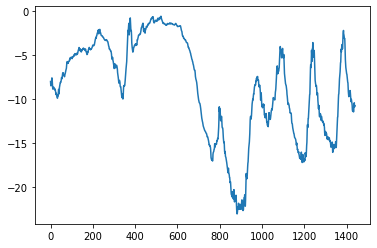

In [5]:
# plot tempreture of first 10 days
plt.plot(range(1440), temp[:1440])

### **2 Preparing the data**
2.1 Normalizing the data 

In [0]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

2.2 Data generator

In [0]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1

    ## Shift the starting index
    nbatch = (max_index - min_index - lookback) // batch_size
    shift = max_index - min_index - lookback - nbatch*batch_size
    min_index_trunc = min_index + shift + lookback - 1

    i = min_index_trunc
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index_trunc, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index_trunc
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [0]:
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data, lookback=lookback, delay=delay,
min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay,
min_index=200001, max_index=300000, step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay,
min_index=300001, max_index=None, step=step, batch_size=batch_size)
val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

In [9]:
val_steps

98559

In [10]:
test_steps

119110

In [0]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    return np.mean(batch_maes)

In [12]:
evaluate_naive_method()

0.2894634211602765

In [21]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

### **4 A basic machine-learning approach**

In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=5,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps/batch_size/10)

Using TensorFlow backend.


Epoch 1/20
5/5 [==============================] - 1s 260ms/step - loss: 5.1376 - val_loss: 1.6969
Epoch 2/20
5/5 [==============================] - 1s 189ms/step - loss: 3.2826 - val_loss: 5.3764
Epoch 3/20
5/5 [==============================] - 1s 207ms/step - loss: 2.9897 - val_loss: 3.8367
Epoch 4/20
5/5 [==============================] - 1s 194ms/step - loss: 2.5050 - val_loss: 3.0445
Epoch 5/20
5/5 [==============================] - 1s 188ms/step - loss: 2.3810 - val_loss: 2.8506
Epoch 6/20
5/5 [==============================] - 1s 197ms/step - loss: 2.2191 - val_loss: 1.1182
Epoch 7/20
5/5 [==============================] - 1s 196ms/step - loss: 2.1318 - val_loss: 3.7050
Epoch 8/20
5/5 [==============================] - 1s 192ms/step - loss: 2.3363 - val_loss: 1.5692
Epoch 9/20
5/5 [==============================] - 1s 195ms/step - loss: 2.1432 - val_loss: 4.5523
Epoch 10/20
5/5 [==============================] - 1s 184ms/step - loss: 2.1514 - val_loss: 2.8634
Epoch 11/20
5/5 [==

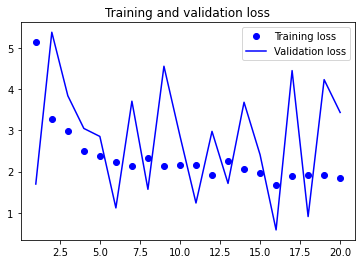

In [14]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### **5 Training and evaluating a GRU-based model**


In [15]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=50,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps/batch_size/10)

Epoch 1/20
50/50 [==============================] - 12s 250ms/step - loss: 0.4824 - val_loss: 0.2081
Epoch 2/20
50/50 [==============================] - 12s 232ms/step - loss: 0.3171 - val_loss: 0.3054
Epoch 3/20
50/50 [==============================] - 12s 239ms/step - loss: 0.3025 - val_loss: 0.3257
Epoch 4/20
50/50 [==============================] - 12s 233ms/step - loss: 0.3003 - val_loss: 0.2704
Epoch 5/20
50/50 [==============================] - 12s 239ms/step - loss: 0.3029 - val_loss: 0.3942
Epoch 6/20
50/50 [==============================] - 12s 238ms/step - loss: 0.2933 - val_loss: 0.7815
Epoch 7/20
50/50 [==============================] - 12s 240ms/step - loss: 0.2963 - val_loss: 0.1476
Epoch 8/20
50/50 [==============================] - 12s 241ms/step - loss: 0.2965 - val_loss: 0.2293
Epoch 9/20
50/50 [==============================] - 12s 237ms/step - loss: 0.2918 - val_loss: 0.0851
Epoch 10/20
50/50 [==============================] - 12s 236ms/step - loss: 0.2918 - val_lo

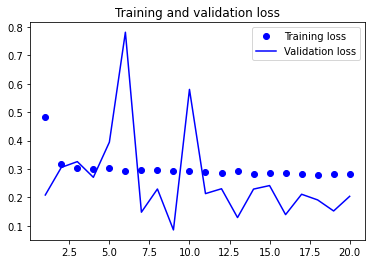

In [16]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


### **6 Training and evaluating a dropout-regularized LSTM-based model**


In [24]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(64,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=50,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps/batch_size/10)

Epoch 1/20
23/50 [============>.................] - ETA: 9s - loss: nan

KeyboardInterrupt: ignored

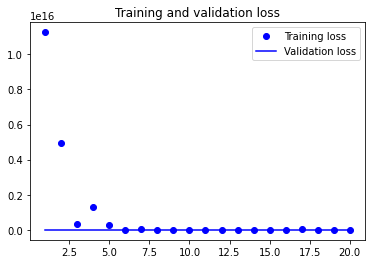

In [22]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

7 Training and evaluating a dropout-regularized, stacked LSTM model


In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.LSTM(64, activation='softmax',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=5,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps/batch_size/10)

In [0]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


8 Analysis and Conclusion
